In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from mlfinlab.online_portfolio_selection.momentum import *
# import seaborn as sns
import optuna
from mlfinlab.portfolio_optimization import ReturnsEstimators
from mlfinlab.portfolio_optimization import HierarchicalRiskParity
import dl_csv
from mlfinlab.portfolio_optimization.herc import HierarchicalEqualRiskContribution
from mlfinlab.online_portfolio_selection.benchmarks import *
import matplotlib.pyplot as plt
import plotly.offline as py
import plotly.graph_objs as go
import plotly.io as pio
from pycoingecko import CoinGeckoAPI
from datetime import date, datetime

In [4]:
1+1

2

In [51]:
cg = CoinGeckoAPI()
cg.ping()
cg.get_price(ids='bitcoin', vs_currencies='usd')

{'bitcoin': {'usd': 9287.66}}

In [52]:
portfolio_coins = ['omisego', 'stellar', '0x', 'ripple', 'tezos', 'loopring', 'binancecoin', 'zcash']

In [53]:
# todays_date = date.today().strftime("%Y-%m-%d")
# from_date = datetime.timestamp(datetime(2020, 1, 1))
# print(from_date)
# datetime.timestamp(date.today())
price_data = cg.get_coin_market_chart_by_id(id=portfolio_coins[-1], vs_currency='btc', days='max')
price_data.keys()
price_data['prices'][-1]


[1594613151000, 0.0067015501177230125]

In [54]:
for i, row in enumerate(price_data['prices']):
    timestamp = row[0]
    price = row[1]
    timestamp = datetime.utcfromtimestamp(timestamp / 1000)
    row[0] = timestamp
    price_data['prices'][i] = row

price_data['prices'][-1]

[datetime.datetime(2020, 7, 13, 4, 5, 51), 0.0067015501177230125]

In [55]:

my_dataframe = []
for i, coin in enumerate(portfolio_coins):
    price_data = cg.get_coin_market_chart_by_id(id=coin, vs_currency='btc', days='max')
    for pdi, row in enumerate(price_data['prices']):
        timestamp = row[0]
        price = row[1]
        timestamp = datetime.utcfromtimestamp(timestamp / 1000)
        row[0] = timestamp
        price_data['prices'][pdi] = row
    current_dataframe = pd.DataFrame.from_records(price_data['prices'], columns=['timestamp', coin])
    current_dataframe.reset_index(drop=True, inplace=True)
    my_dataframe.append(current_dataframe)

my_dataframe[-1].tail()

,timestamp,zcash
1349,2020-07-09 00:00:00,0.006134
1350,2020-07-10 00:00:00,0.006148
1351,2020-07-11 00:00:00,0.006020
1352,2020-07-12 00:00:00,0.006037
1353,2020-07-13 04:05:51,0.006702


In [91]:
portfolio_dataframe = my_dataframe[0]
for i, mdf in enumerate(my_dataframe):
    if (i) == 0: continue
    portfolio_dataframe = pd.merge(portfolio_dataframe, mdf, how='inner', on=['timestamp'])

portfolio_dataframe.set_index('timestamp', inplace=True, drop=True)
portfolio_dataframe.index = pd.to_datetime(portfolio_dataframe.index)
portfolio_dataframe.head()

# Up portfolio
# portfolio_dataframe = portfolio_dataframe['2019-12-01': datetime.now().strftime('%Y-%m-%d')]

,omisego,stellar,0x,ripple,tezos,loopring,binancecoin,zcash
timestamp,,,,,,,,
2018-07-03,0.001265,0.000032,0.000145,0.000074,0.000445,0.000056,0.002205,0.027846
2018-07-04,0.001224,0.000032,0.000137,0.000074,0.000315,0.000055,0.002166,0.027480
2018-07-05,0.001237,0.000032,0.000146,0.000075,0.000300,0.000055,0.002122,0.027436
2018-07-06,0.001259,0.000031,0.000153,0.000073,0.000234,0.000051,0.002042,0.026638
2018-07-07,0.001238,0.000031,0.000154,0.000072,0.000272,0.000051,0.001998,0.026611


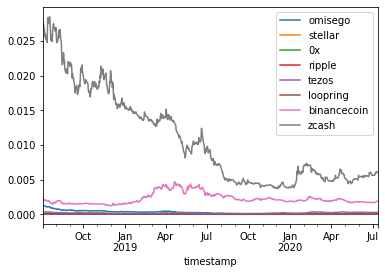

In [92]:

portfolio_dataframe.plot()

In [96]:
study = optuna.create_study(study_name="eg", storage='sqlite:///example.db', direction='maximize')


[I 2020-07-13 10:38:13,838] A new study created with name: eg


In [95]:
study = optuna.delete_study(study_name="eg", storage='sqlite:///example.db')

In [97]:
study = optuna.load_study(study_name="eg", storage='sqlite:///example.db')

In [98]:
def obj(trial):
    eta = trial.suggest_loguniform('eta', 0.001, 2)

    # Multiplicative update
    temp = EG('MU', eta)
    temp.allocate(portfolio_dataframe, verbose=True)

    data_len, period = portfolio_dataframe.shape[0], 10
    for i in range(0, period):
        time = data_len * i // period
        trial.report(temp.portfolio_return.iloc[time][0], step=time)

    return temp.portfolio_return.iloc[-1][0]

In [99]:
number = 10
study.optimize(obj, n_trials=number)

Progress: |██████████████████████████████████████████████████| 100.0% Complete
[I 2020-07-13 10:38:19,420] Finished trial#0 with value: 0.46641794771078227 with parameters: {'eta': 0.005238059044308812}. Best is trial#0 with value: 0.46641794771078227.
Progress: |██████████████████████████████████████████████████| 100.0% Complete
[I 2020-07-13 10:38:20,391] Finished trial#1 with value: 0.46492280899961497 with parameters: {'eta': 0.02018577345336082}. Best is trial#0 with value: 0.46641794771078227.
Progress: |██████████████████████████████████████████████████| 100.0% Complete
[I 2020-07-13 10:38:21,493] Finished trial#2 with value: 0.4668202892976167 with parameters: {'eta': 0.0012407607999422204}. Best is trial#2 with value: 0.4668202892976167.
Progress: |██████████████████████████████████████████████████| 100.0% Complete
[I 2020-07-13 10:38:22,601] Finished trial#3 with value: 0.466707715427004 with parameters: {'eta': 0.002358133539404032}. Best is trial#2 with value: 0.46682028929

In [100]:
# study_df = study.trials_dataframe(attrs=('number', 'value', 'params', 'state'))
print("Best parameter: ", study.best_params['eta'])
print("Best returns: ", study.best_trial.value)
print("Best trial number: ", study.best_trial.number)

Best parameter:0.0012407607999422204
Best returns:0.4668202892976167
Best trial number:2


In [101]:
fig = optuna.visualization.plot_slice(study)
fig.update_layout(title_text="EG ETA between 0 and 2", yaxis_title_text="Relative Returns")
fig.show()

In [102]:
mu = EG(update_rule='MU', eta=study.best_params['eta'])
# mu = EG(update_rule='MU', eta=3)
mu.allocate(asset_prices=portfolio_dataframe, verbose=True)

Progress: |██████████████████████████████████████████████████| 100.0% Complete


In [106]:
mu.all_weights.tail(1)

,omisego,stellar,0x,ripple,tezos,loopring,binancecoin,zcash
timestamp,,,,,,,,
2020-07-12,0.124864,0.124973,0.125008,0.12497,0.125151,0.12496,0.125143,0.124931


In [117]:
mu.all_weights.plot()

In [111]:
mu.portfolio_return['Returns'].tail()

timestamp
2020-07-08    0.430526
2020-07-09    0.453741
2020-07-10    0.452406
2020-07-11    0.448322
2020-07-12    0.466820
Name: Returns, dtype: float64

In [116]:
fig = go.Figure()
idx = mu.portfolio_return.index
fig.add_trace(go.Scatter(x=idx, y=mu.portfolio_return['Returns'], name="EG"))
fig.update_layout(title='Momentum Strategy on Crypto', xaxis_title='Date', yaxis_title='Relative Returns')
fig.show()

In [45]:
mu.weights

array([0.00301378, 0.02124016, 0.05677659, 0.01730784, 0.61292928,
       0.03169424, 0.24833743, 0.00870069])

In [47]:
mu.relative_return[-1]

array([0.99589112, 1.06723215, 1.06736242, 1.01911712, 1.06475788,
       1.08407398, 1.02883581, 1.00275321])

In [109]:
mu.asset_prices.tail()

,omisego,stellar,0x,ripple,tezos,loopring,binancecoin,zcash
timestamp,,,,,,,,
2020-07-08,0.000165,0.000008,0.000044,0.000020,0.000271,0.000010,0.001813,0.005934
2020-07-09,0.000172,0.000009,0.000048,0.000022,0.000281,0.000011,0.001823,0.006134
2020-07-10,0.000168,0.000010,0.000046,0.000022,0.000274,0.000010,0.001821,0.006148
2020-07-11,0.000166,0.000010,0.000044,0.000021,0.000274,0.000010,0.001854,0.006020
2020-07-12,0.000166,0.000010,0.000047,0.000022,0.000291,0.000011,0.001908,0.006037


Progress: |██████████████████████████████████████████████████| 100.0% Complete
timestamp
2020-07-12    0.444849
Freq: W-SUN, Name: Returns, dtype: float64


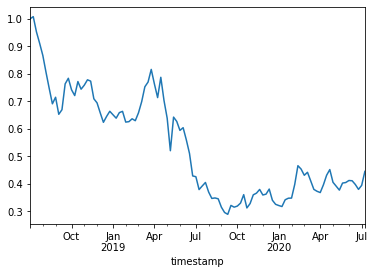

In [108]:
bah = BAH()
bah.allocate(asset_prices=portfolio_dataframe, resample_by='W', verbose=True)
print(bah.portfolio_return['Returns'].tail(1))
bah.portfolio_return['Returns'].plot()